# Home Credit Default Risk

## EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings

warnings.filterwarnings("ignore")

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

import warnings

warnings.simplefilter("ignore", UserWarning)
InteractiveShell.ast_node_interactivity = "all"
import sys

sys.path.append("../")
from helpers import *

In [ ]:
# https://www.kaggle.com/questions-and-answers/118932
# Max rows and columns of pandas dataframe
pd.options.display.max_rows, pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option(
    "display.max_rows", None
)  # Print unlimited number of rows by setting to None, default is 10
pd.set_option(
    "display.max_columns", None
)  # Do not truncate columns to display all of them by setting to None
pd.set_option(
    "display.width", None
)  # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option(
    "display.max_colwidth", None
)  # Auto detect the max size of column and print contents of that column without truncation

In [28]:
def reduce_mem_usage(df):
    """iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


print("-" * 80)
print("train")
train = import_data("data/application_train.csv")

print("-" * 80)
print("test")
test = import_data("data/application_test.csv")

print("-" * 80)
print("bureau_balance")
bureau_balance = import_data("data/bureau_balance.csv")

print("-" * 80)
print("bureau")
bureau = import_data("data/bureau.csv")

print("-" * 80)
print("credit_card_balance")
credit_card = import_data("data/credit_card_balance.csv")

print("-" * 80)
print("installments_payments")
installments = import_data("data/installments_payments.csv")

print("-" * 80)
print("pos_cash_balance")
pos_cash = import_data("data/POS_CASH_balance.csv")

print("-" * 80)
print("previous_application")
previous_app = import_data("data/previous_application.csv")

### Data model

There are 7 different sources of data:

- **train/application_test**: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

- **bureau**: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

- **bureau_balance**: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

- **previous_application**: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

- **POS_CASH_BALANCE**: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

- **credit_card_balance**: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

- **installments_payment**: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.


#### Schema visualization
<img src="../images/home_credit.png" alt="Alternative text" />

#### Column Description

In [5]:
desc = pd.read_csv("../data/HomeCredit_columns_description.csv", encoding="latin")
desc.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


### Data glimpse

In [6]:
print("train -  rows:", train.shape[0], " columns:", train.shape[1])
print("application_test -  rows:", test.shape[0], " columns:", test.shape[1])
print("bureau -  rows:", bureau.shape[0], " columns:", bureau.shape[1])
print(
    "bureau_balance -  rows:",
    bureau_balance.shape[0],
    " columns:",
    bureau_balance.shape[1],
)
print(
    "credit_card_balance -  rows:",
    credit_card.shape[0],
    " columns:",
    credit_card.shape[1],
)
print(
    "installments_payments -  rows:",
    installments.shape[0],
    " columns:",
    installments.shape[1],
)
print(
    "previous_application -  rows:",
    previous_app.shape[0],
    " columns:",
    previous_app.shape[1],
)
print("POS_CASH_balance -  rows:", pos_cash.shape[0], " columns:", pos_cash.shape[1])

train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121
bureau -  rows: 1716428  columns: 17
bureau_balance -  rows: 27299925  columns: 3
credit_card_balance -  rows: 3840312  columns: 23
installments_payments -  rows: 13605401  columns: 8
previous_application -  rows: 1670214  columns: 37
POS_CASH_balance -  rows: 10001358  columns: 8


In [7]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [8]:
train.shape, test.shape
train.shape[0] / (train.shape[0] + test.shape[0]) * 100  # Percentage of train data

((307511, 122), (48744, 121))

86.31766571697239

### Data imbalance

In [10]:
print(start + "1 = client with payment difficulties" + end)
print(start + "0 = all other cases" + end)
train.TARGET.value_counts(normalize=True)

1 = client with payment difficulties
0 = all other cases


0    0.919271
1    0.080729
Name: TARGET, dtype: float64

### Missing values

In [11]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )

    # Print some summary information
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


print(start + "Train Data" + end)
missing_values_table(train).head(10)
print(start + "Test Data" + end)
missing_values_table(test).head(10)
print(start + "Bureau Data" + end)
missing_values_table(bureau).head(10)
print(start + "Bureau Balance Data" + end)
missing_values_table(bureau_balance).head(10)
print(start + "Credit Card Data" + end)
missing_values_table(credit_card).head(10)
print(start + "Installments Data" + end)
missing_values_table(installments).head(10)
print(start + "POS Cash Data" + end)
missing_values_table(pos_cash).head(10)
print(start + "Previous Application Data" + end)
missing_values_table(previous_app).head(10)

Train Data
Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Test Data
Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


Bureau Data
Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


Bureau Balance Data
Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Credit Card Data
Your selected dataframe has 23 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


Installments Data
Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


POS Cash Data
Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CNT_INSTALMENT_FUTURE,26087,0.3
CNT_INSTALMENT,26071,0.3


Previous Application Data
Your selected dataframe has 37 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


In [12]:
def handle_missing_values(
    dataframe, high_threshold=50.0, placeholder_for_categorical="Unknown"
):
    for column in dataframe.columns:
        missing_percent = dataframe[column].isnull().mean() * 100

        # Drop columns with a high percentage of missing values
        if missing_percent > high_threshold:
            dataframe.drop(column, axis=1, inplace=True)

        # Impute missing values for numeric columns with the median
        elif dataframe[column].dtype in ["float64", "int64"]:
            dataframe[column].fillna(dataframe[column].median(), inplace=True)

        # Impute missing values for categorical columns with a placeholder or mode
        else:
            most_frequent = (
                dataframe[column].mode()[0]
                if dataframe[column].mode().empty == False
                else placeholder_for_categorical
            )
            dataframe[column].fillna(most_frequent, inplace=True)

    return dataframe


train = handle_missing_values(train, high_threshold=60)
bureau = handle_missing_values(bureau, high_threshold=50)
previous_app = handle_missing_values(previous_app, high_threshold=60)

### Variable types

In [13]:
train.dtypes.value_counts()

float16     45
int8        37
float32      4
int32        2
category     2
int16        2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
dtype: int64

### Data visualization

In [14]:
def plot_distribution(feature, color, desc):
    plt.figure(figsize=(10, 6))
    plt.title(f"Distribution of {feature} ({desc})")
    sns.distplot(train[feature].dropna(), color=color, kde=True, bins=100)
    plt.show()


def plot_distribution_comp(var, nrow=2):

    i = 0
    t1 = train.loc[train["TARGET"] != 0]
    t0 = train.loc[train["TARGET"] == 0]

    sns.set_style("whitegrid")
    plt.figure()
    fig, ax = plt.subplots(nrow, 2, figsize=(12, 6 * nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow, 2, i)
        sns.kdeplot(t1[feature], bw=0.5, label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5, label="TARGET = 0")
        plt.ylabel("Density plot", fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis="both", which="major", labelsize=12)
    plt.show()

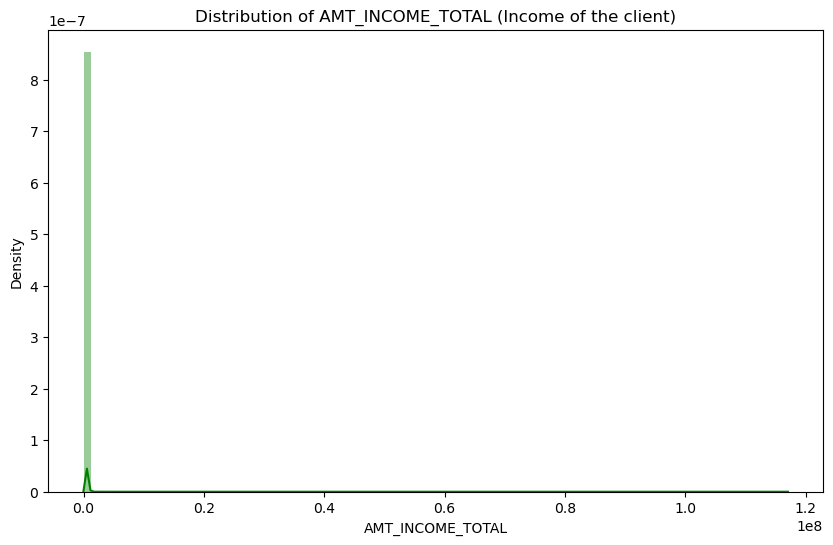

In [15]:
plot_distribution("AMT_INCOME_TOTAL", "green", "Income of the client")

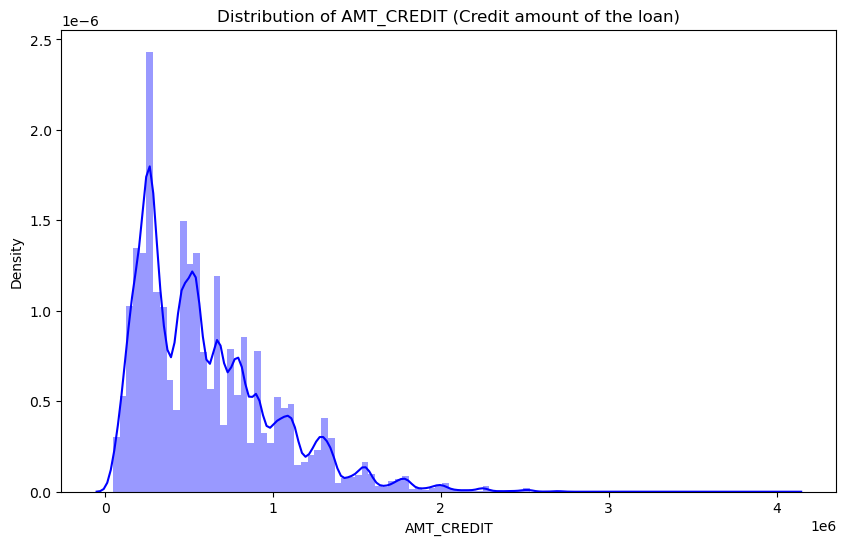

In [16]:
plot_distribution("AMT_CREDIT", "blue", "Credit amount of the loan")

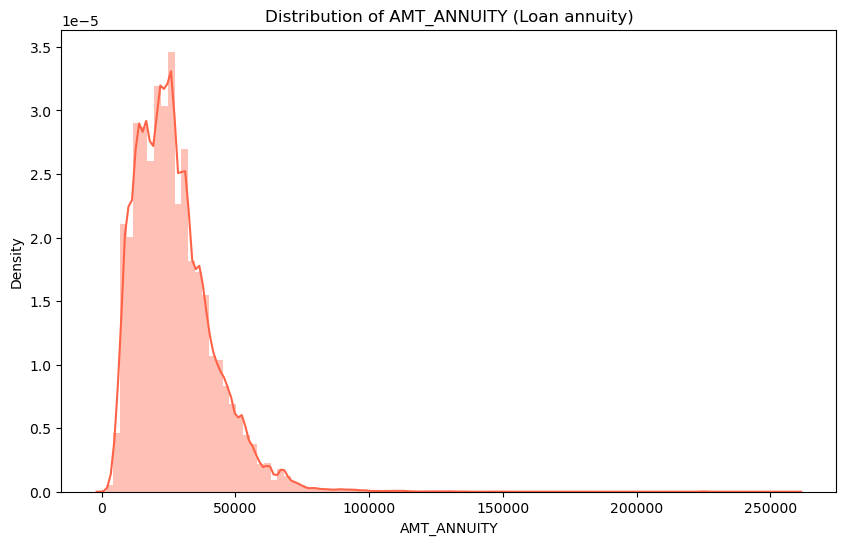

In [17]:
plot_distribution("AMT_ANNUITY", "tomato", "Loan annuity")

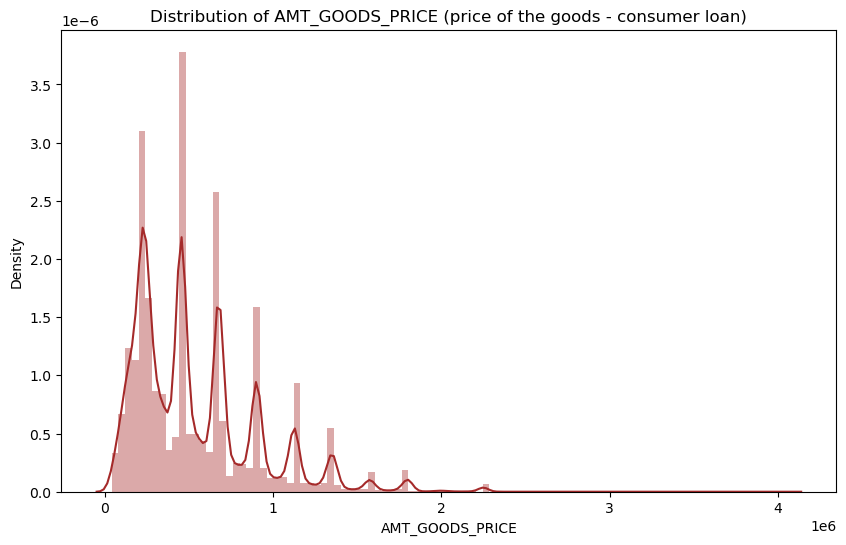

In [18]:
plot_distribution("AMT_GOODS_PRICE", "brown", "price of the goods - consumer loan")

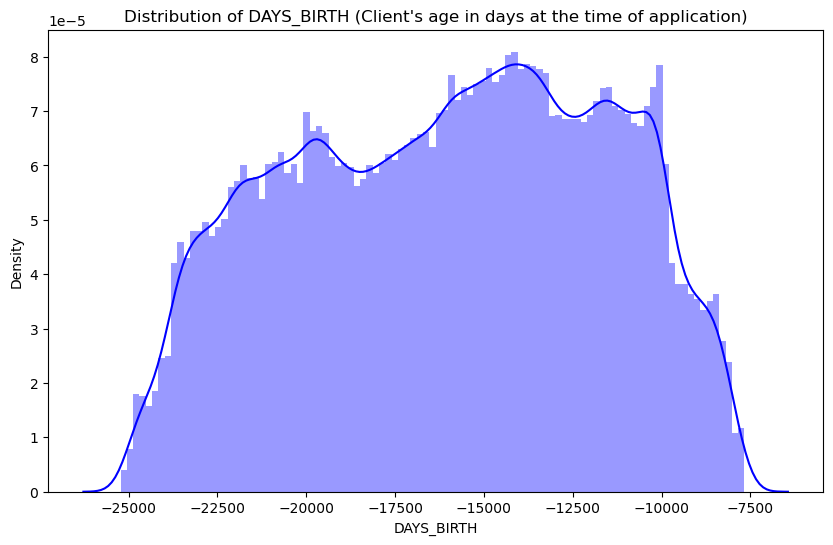

In [19]:
plot_distribution(
    "DAYS_BIRTH", "blue", "Client's age in days at the time of application"
)

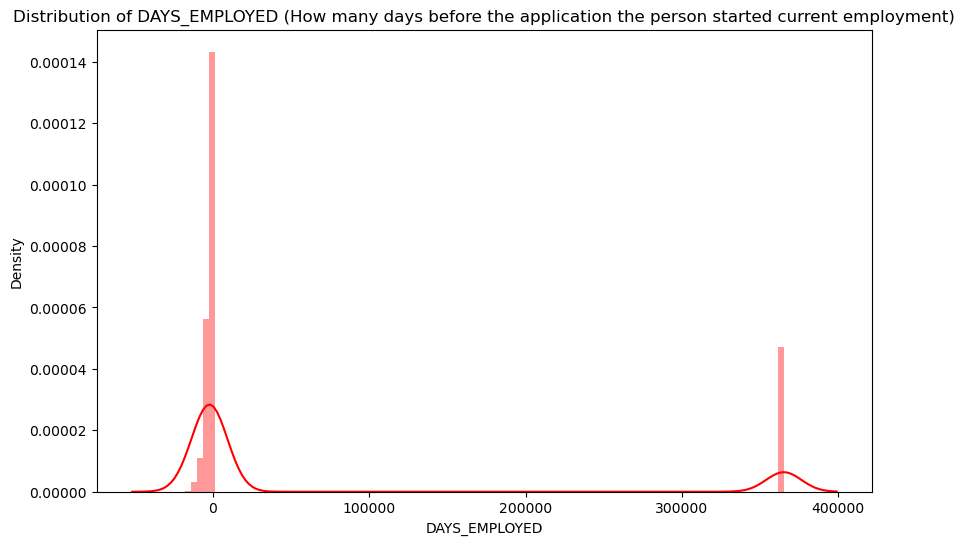

In [20]:
plot_distribution(
    "DAYS_EMPLOYED",
    "red",
    "How many days before the application the person started current employment",
)

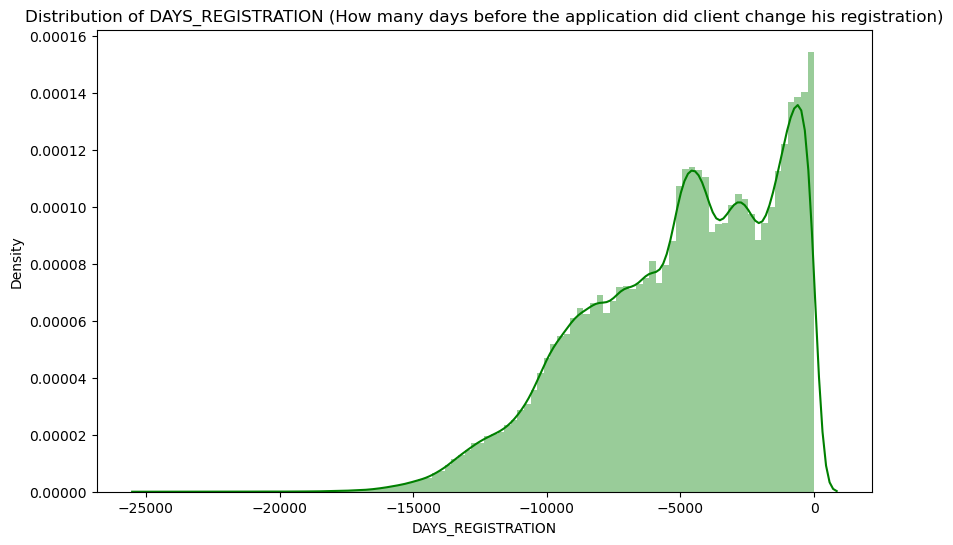

In [21]:
plot_distribution(
    "DAYS_REGISTRATION",
    "green",
    "How many days before the application did client change his registration",
)

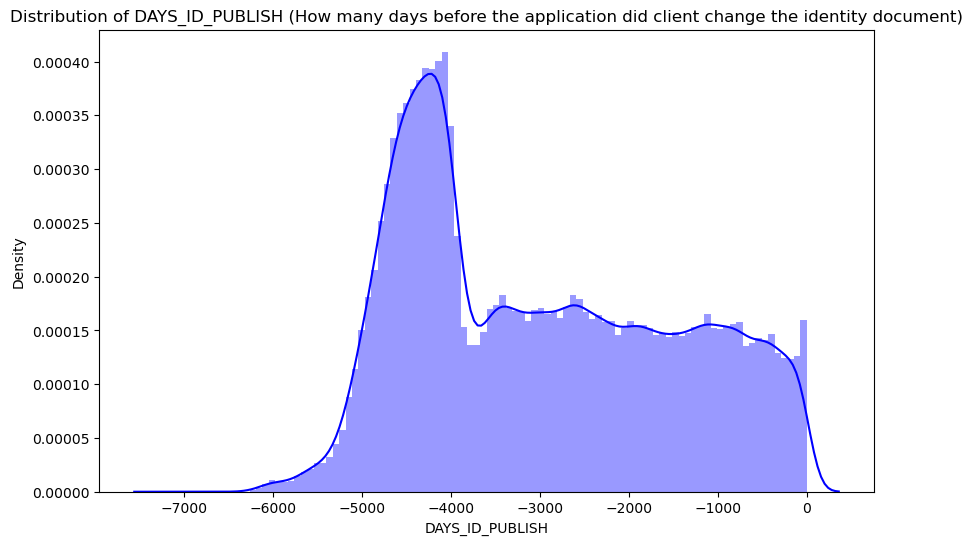

In [22]:
plot_distribution(
    "DAYS_ID_PUBLISH",
    "blue",
    "How many days before the application did client change the identity document",
)

### Comparison plots

<Figure size 640x480 with 0 Axes>

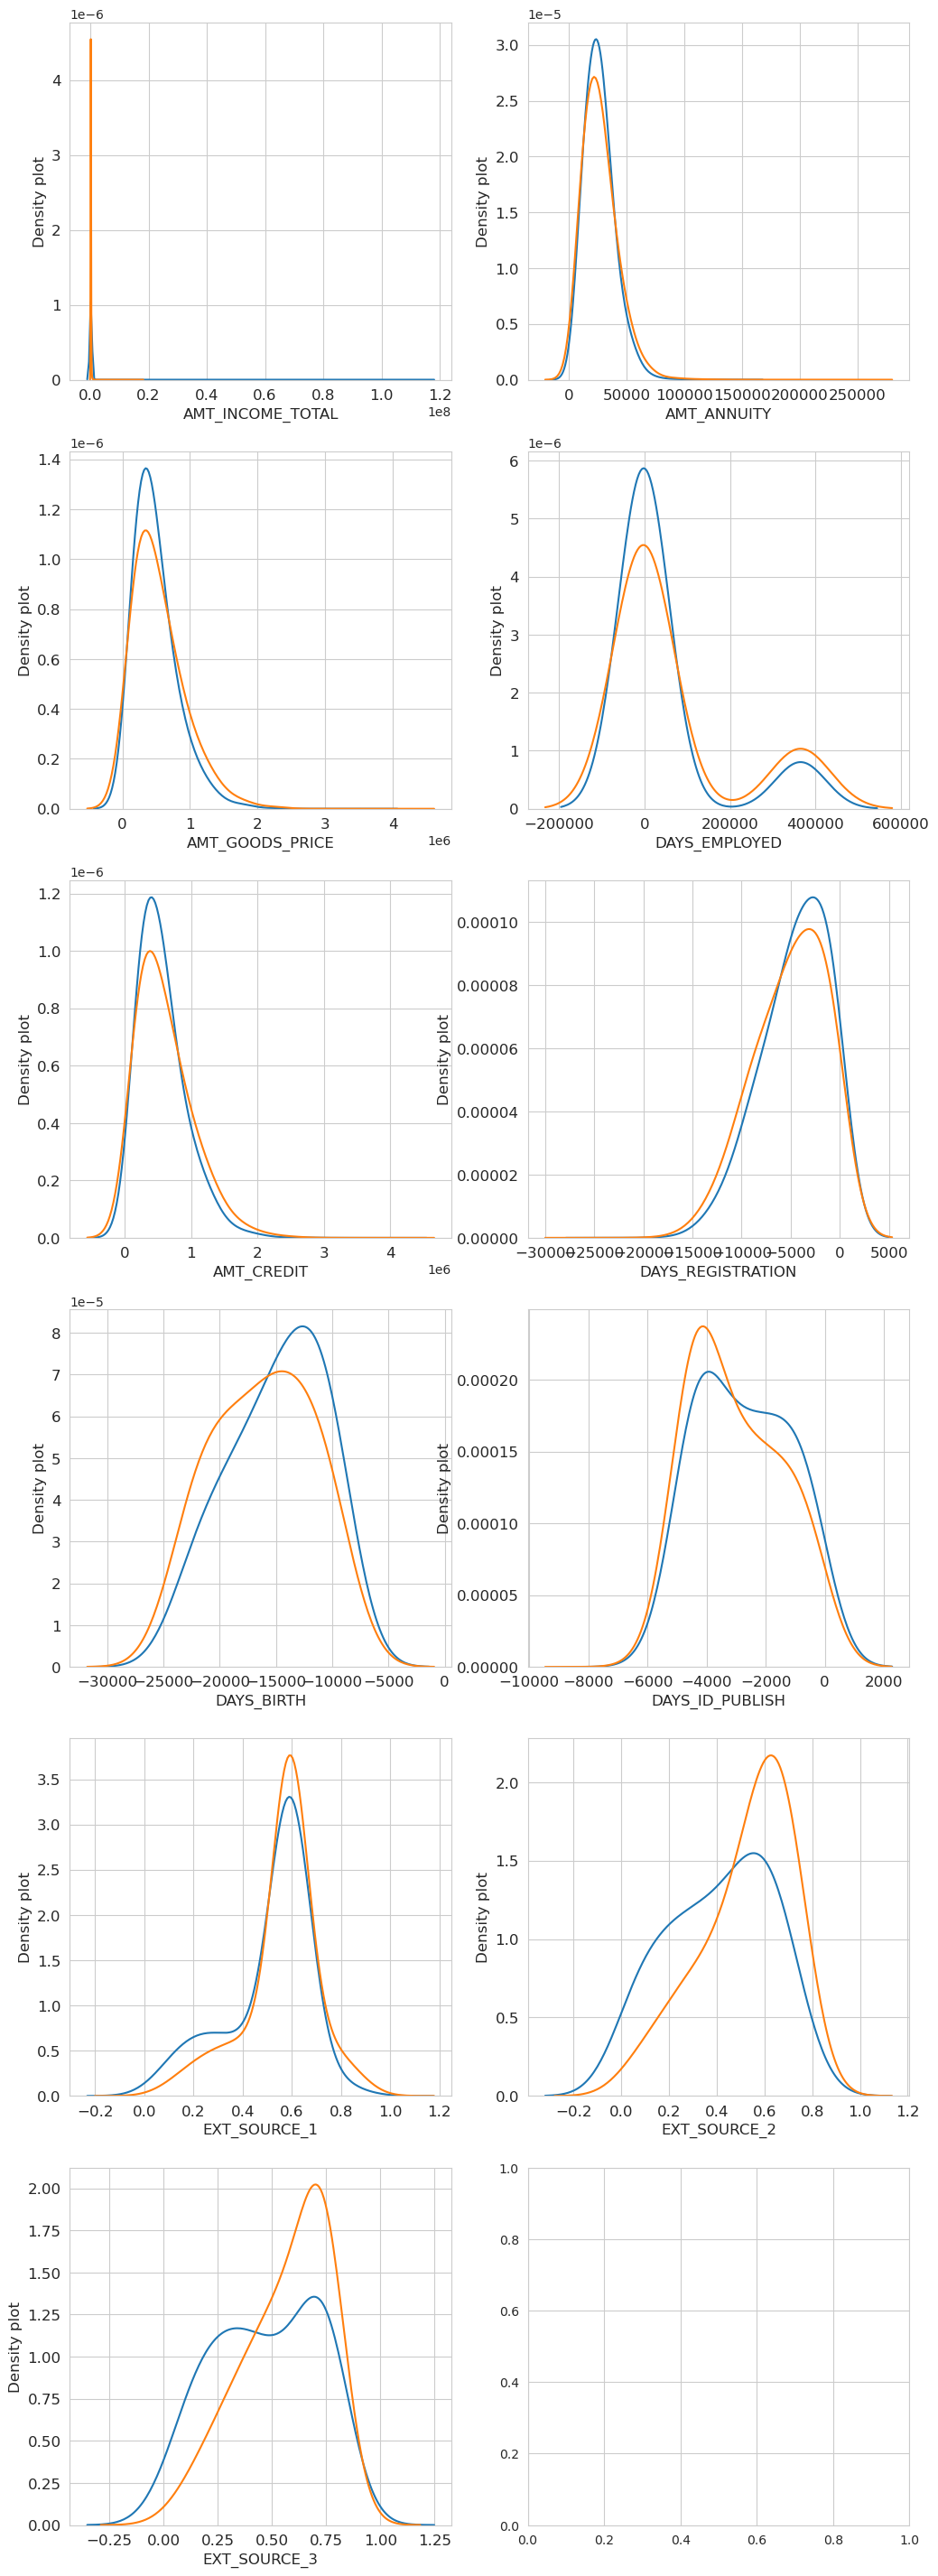

In [23]:
var = [
    "AMT_INCOME_TOTAL",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "DAYS_EMPLOYED",
    "AMT_CREDIT",
    "DAYS_REGISTRATION",
    "DAYS_BIRTH",
    "DAYS_ID_PUBLISH",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
]
plot_distribution_comp(var, nrow=6)